In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Here's some functions I'll use for my own data cleanup efforts

def print_lots_of_info(df):
    df.info(show_counts=True)
    print(df.shape)
    print()
    print(df.describe())
    print()
    print(df.head(5))
    print()
    print(df.sample(5))
    print()

def do_each_col(df):
    for c in df.columns:
        print(c, 'count of unique values =', df[c].nunique())
        # count the number of duplicated values in each column
        mask = df.duplicated(subset=c, keep=False)
        duplicated_values = df.loc[mask, c].unique()
        num_duplicates = len(duplicated_values)
        if num_duplicates > 0:
            print(f"Column '{c}' has {num_duplicates} duplicated values: {duplicated_values}")
        print()

## Find and remove duplicate values (and describe why you make your choices)

### `orders` data frame

In [2]:
# Change Column Names, Check for duplicated orders, and Drop duplicated orders
i_df = pd.read_csv('./data/instacart_orders.csv', sep=';')
i_df = i_df.rename(columns={
    'order_id': 'id',
    'order_number': 'user_order_number',
    'order_dow': 'day_of_week_numeral'
})
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])
i_df = i_df.drop_duplicates()

In [3]:
# Make a new day_of_week column, for future readability
weekday_dict = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}

i_df['day_of_week'] = i_df['day_of_week_numeral'].map(weekday_dict)
# print_lots_of_info(i_df)
# do_each_col(i_df)


In [4]:
# Change Col data types to save space and make it easier to use the data later

i_df['id'] = i_df['id'].astype(str)
i_df = i_df.reset_index(drop=True)

# print(np.array_equal(i_df['user_order_number'], i_df['user_order_number'].astype('uint8')))
i_df['user_order_number'] = i_df['user_order_number'].astype('uint8')

# print(np.array_equal(i_df['day_of_week_numeral'], i_df['day_of_week_numeral'].astype('uint8')))
i_df['day_of_week_numeral'] = i_df['day_of_week_numeral'].astype('uint8')

# print(np.array_equal(i_df['order_hour_of_day'], i_df['order_hour_of_day'].astype('uint8')))
i_df['order_hour_of_day'] = i_df['order_hour_of_day'].astype('uint8')

i_df['days_since_prior_order'] = i_df['days_since_prior_order'].fillna(-1)
# print(np.array_equal(i_df['days_since_prior_order'], i_df['days_since_prior_order'].astype('int8')))
i_df['days_since_prior_order'] = i_df['days_since_prior_order'].astype('int8')

# print_lots_of_info(i_df)


### `products` data frame

In [5]:
# Check for fully duplicate rows
p_df = pd.read_csv('./data/products.csv', sep=';')
p_df = p_df.rename(columns={
    'product_id': 'id',
    'product_name': 'name'
})
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])

In [6]:
# Set index, fill na values, and Change Col data types to save space and
# to make it easier to use the data later
p_df['id'] = p_df['id'].astype(str)
p_df = p_df.reset_index(drop=True)

p_df['aisle_id'] = p_df['aisle_id'].astype(str)
p_df['department_id'] = p_df['department_id'].astype(str)
p_df['name'].fillna('__unknown__', inplace=True)
p_df['name'] = p_df['name'].str.lower()
# print_lots_of_info(p_df)

In [7]:
# Check for just duplicate product names (convert names to lowercase to compare better)
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0]) 
# there are no duplicates

### `departments` data frame

In [8]:
d_df = pd.read_csv('./data/departments.csv', sep=';')
d_df = d_df.rename(columns={
    'department_id': 'id',
    'department': 'name'
})

# print(d_df.duplicated().value_counts(), 'out of', d_df.shape[0])

In [9]:
d_df['id'] = d_df['id'].astype(str)
d_df = d_df.reset_index(drop=True)
# print_lots_of_info(d_df)

### `aisles` data frame

In [10]:
a_df = pd.read_csv('./data/aisles.csv', sep=';')
a_df = a_df.rename(columns={
    'aisle_id': 'id',
    'aisle': 'name'
})

# print(a_df.duplicated().value_counts(), 'out of', a_df.shape[0])

In [11]:
a_df['id'] = a_df['id'].astype(str)
a_df = a_df.reset_index(drop=True)

# print_lots_of_info(a_df)

### `order_products` data frame

In [12]:
# Check for fullly duplicate rows
o_df = pd.read_csv('./data/order_products.csv', sep=';')
o_df = o_df.rename(columns={
    'add_to_cart_order': 'cart_item_id'
})

o_df = o_df.dropna(subset=['cart_item_id'])

# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

In [13]:
# Double check for any other tricky duplicates
o_df['order_id'] = o_df['order_id'].astype(str)
o_df['product_id'] = o_df['product_id'].astype(str)
# print(np.array_equal(o_df['cart_item_id'], o_df['cart_item_id'].astype('uint8')))
o_df['cart_item_id'] = o_df['cart_item_id'].astype('uint8')
# print(np.array_equal(o_df['reordered'], o_df['reordered'].astype('uint8')))
o_df['reordered'] = o_df['reordered'].astype('uint8')
# print_lots_of_info(o_df)
# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

# [A] Easy (must complete all to pass)

### [A1] Verify that the `'order_hour_of_day'` and `'day_of_week_numeral'` values in the `instacart_orders` tables are sensible (i.e. `'order_hour_of_day'` ranges from 0 to 23 and `'day_of_week_numeral'` ranges from 0 to 6)

In [14]:
print(pd.Series(i_df['day_of_week_numeral'].unique()).sort_values())

2    0
5    1
6    2
4    3
3    4
1    5
0    6
dtype: uint8


In [15]:
print(pd.Series(i_df['order_hour_of_day'].unique()).sort_values())

12     0
15     1
18     2
20     3
23     4
22     5
17     6
16     7
5      8
9      9
11    10
4     11
1     12
0     13
13    14
7     15
8     16
14    17
6     18
2     19
3     20
19    21
10    22
21    23
dtype: uint8


The days of the Week and the Hours of the day look good. No missing values. No nonsense values.

### [A2] What time of day do people shop for groceries?

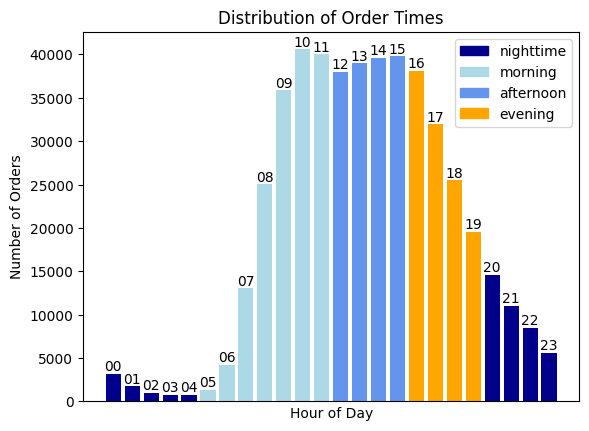

In [16]:
# Make an optically pleasing color scheme
colors=[
    'darkblue','darkblue','darkblue','darkblue','darkblue', # Nighttime 20-04
    'lightblue','lightblue','lightblue','lightblue','lightblue','lightblue','lightblue', # Morning 05-11
    'cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue', # Afternoon 12-15
    'orange','orange','orange','orange', # Evening 16-19
    'darkblue','darkblue','darkblue','darkblue' # Nighttime 20-04
]
color_labels = {
    'nighttime': 'darkblue',
    'morning': 'lightblue',
    'afternoon': 'cornflowerblue',
    'evening': 'orange'
}

# compute the histogram
hist, bins = np.histogram(i_df['order_hour_of_day'], bins=24)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    time_bin = (bins[i], bins[i+1])
    color=colors[i]
    ax.bar(i, hist[i], color=color)
    ax.text(i, hist[i]+0.005, '{:02d}'.format(i), ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Times')

# make a handy legend
handles = [plt.Rectangle((0,0),1,1, color=color_labels[label]) for label in color_labels]
labels = color_labels.keys()
ax.legend(handles, labels)

plt.show()


It appears nighttime is not a popular time to order groceries, I'd speculate that that's because a lot of stores are closed during those times and also 'normal' people sleep during those times. Looks like popular times are late Mornings and Late Afternoon.

### [A3] What day of the week do people shop for groceries?

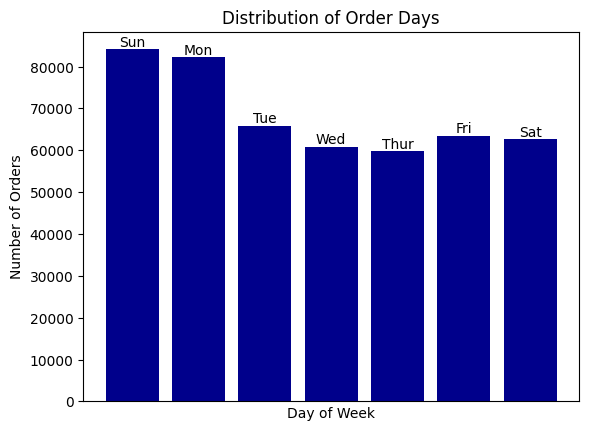

In [17]:
# print(i_df.groupby(['day_of_week_numeral']).size().sort_values(ascending=False))
dow = ["Sun", "Mon", "Tue", "Wed", "Thur", "Fri", "Sat"]

# compute the histogram
hist, bins = np.histogram(i_df['day_of_week_numeral'], bins=7)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    ax.bar(i, hist[i], color='darkblue')
    ax.text(i, hist[i]+0.005, dow[i], ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Days')

plt.show()

Looks like Sunday and Monday are popular Days. I'd speculate that that's because a lot of people plan their weeks on those days and remember that they need Food that week.

### [A4] How long do people wait until placing another order?

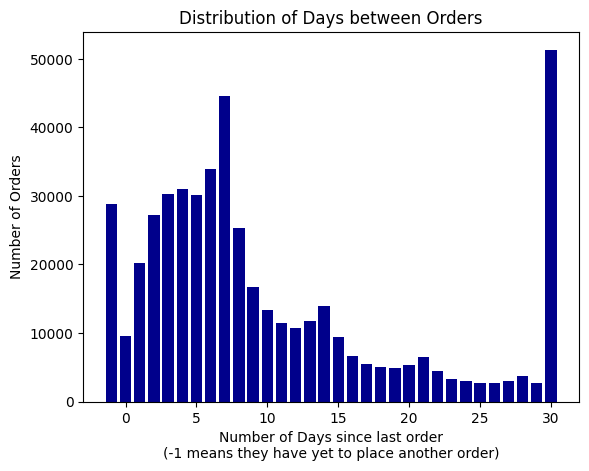

In [18]:
# compute the histogram
hist, bins = np.histogram(i_df['days_since_prior_order'], bins=32)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins)-1):
    i = i - 1
    ax.bar(i, hist[i+1], color='darkblue')
    
# customize the plot
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_xlabel('Number of Days since last order\n(-1 means they have yet to place another order)', fontsize=10)
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Days between Orders')

plt.show()

It looks like the most popular interval is listed as 30 days, maybe the data is supposed to represent '30 or more' days or something like that. In second place is 7 days, which makes sense since a lot of people plan their lives on a weekly basis.

# [B] Medium (must complete all to pass)

### [B1] Is there a difference in `'order_hour_of_day'` distributions on Wednesdays and Saturdays? Plot the histograms for both days and describe the differences that you see.

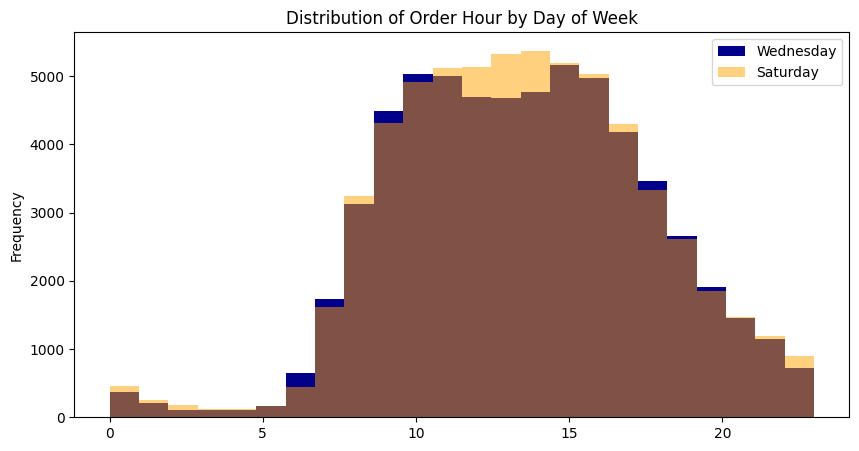

In [36]:
# create two subsets of the data for Wednesdays and Saturdays
wed_df = i_df[i_df['day_of_week'] == 'Wednesday']
sat_df = i_df[i_df['day_of_week'] == 'Saturday']

# create the histogram for Wednesdays
wed_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=1, 
    label='Wednesday', 
    color='darkblue',
    xlabel='Order Hour of Day',
    ylabel='Number of Orders',
    title='Distribution of Order Hour by Day of Week',
    legend=True,
    figsize=[10,5]
)

# create the histogram for Saturdays
sat_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=0.5, 
    label='Saturday', 
    color='orange',
    legend=True
)

plt.show()


It would appear that slightly more orders are placed in the afternoon on Saturdays than on Wednesdays. That makes sense since most people have Sundays off and work on Wednesdays, so they're free to order Groceries.

### [B2] What's the distribution for the number of orders per customer?

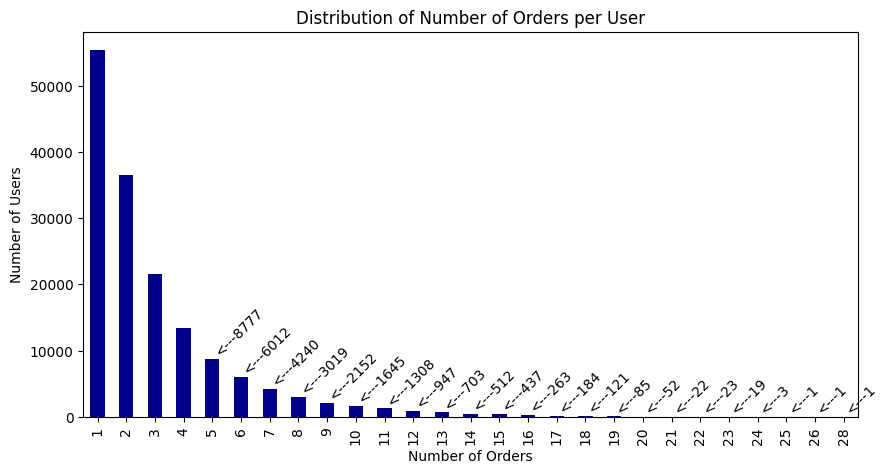

In [29]:
# Count the number of orders per user
user_order_counts = i_df.groupby('user_id')['id'].count()

# Count the number of users who have ordered each number of orders
order_counts = user_order_counts.value_counts()

# Sort the order_counts DataFrame by index
order_counts = order_counts.sort_index()

# Create a bar chart with the number of orders on the x-axis and the number of users on the y-axis
order_counts.plot(
    kind='bar',
    xlabel='Number of Orders',
    ylabel='Number of Users',
    title='Distribution of Number of Orders per User',
    color='darkblue',
    figsize=[10, 5]
)

# Add labels to each bar with a value less than 10,000
for i, v in enumerate(order_counts.values):
    if v < 10_000:
        plt.text(i, v, '<---'+str(v), color='black', ha='left', va='bottom', rotation=45)

# Display the plot
plt.show()


It looks like the most common quantity of orders per customer is 1 with what seems to be a moderate logorithmic decline after. Maybe we can add some additional incentives for users to order more. For example, a discount for every 5th or 7th order.

One Customer seems to have ordered 28 times, though. 

### [B3] What are the top 20 popular products (display their id and name)?

In [21]:
# Isolate product ids (and frequencies) of the top 20 most frequently Ordered Products from the order_products df
order_freq = o_df.groupby('product_id')['order_id'].count().sort_values(ascending=False).head(20).reset_index()

# Check Data
# print(order_freq)

   product_id  order_id
0       24852     66046
1       13176     53295
2       21137     37035
3       21903     33970
4       47209     29772
5       47766     24689
6       47626     21495
7       16797     20017
8       26209     19689
9       27845     19600
10      27966     19194
11      22935     15897
12      24964     15290
13      45007     14584
14      39275     13879
15      49683     13674
16      28204     12544
17       5876     12231
18       8277     11992
19      40706     11781


In [22]:
# Map product_id to id in p_df and add the name column
order_freq['name'] = order_freq['product_id'].apply(lambda x: p_df.set_index('id').loc[x, 'name'])

# Add order count column
order_freq = order_freq.rename(columns={'order_id': 'count'})

# Display order_freq
# print(order_freq)

   product_id  count                      name
0       24852  66046                    banana
1       13176  53295    bag of organic bananas
2       21137  37035      organic strawberries
3       21903  33970      organic baby spinach
4       47209  29772      organic hass avocado
5       47766  24689           organic avocado
6       47626  21495               large lemon
7       16797  20017              strawberries
8       26209  19689                     limes
9       27845  19600        organic whole milk
10      27966  19194       organic raspberries
11      22935  15897      organic yellow onion
12      24964  15290            organic garlic
13      45007  14584          organic zucchini
14      39275  13879       organic blueberries
15      49683  13674            cucumber kirby
16      28204  12544        organic fuji apple
17       5876  12231             organic lemon
18       8277  11992  apple honeycrisp organic
19      40706  11781    organic grape tomatoes


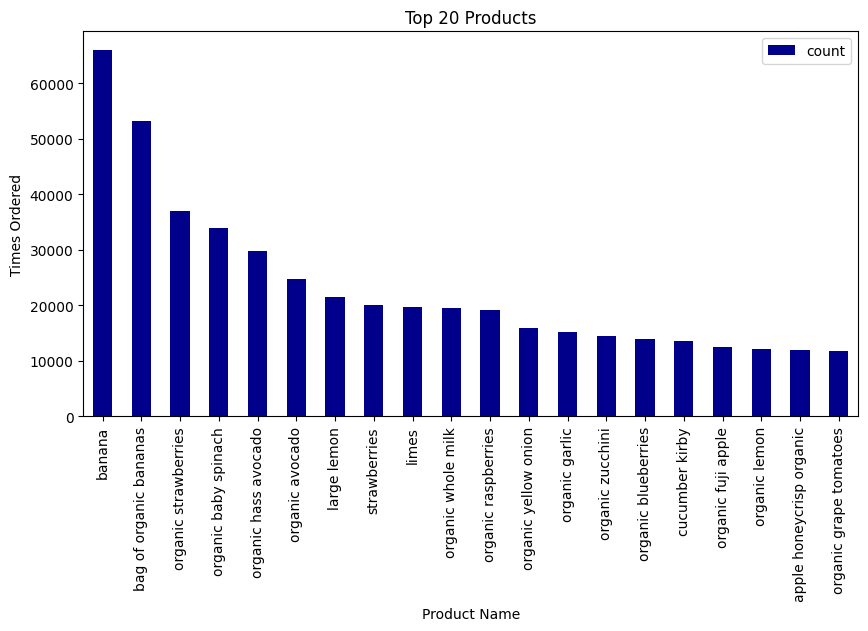

In [41]:
# Make a Bar Chart
order_freq.plot(
    kind='bar',
    x='name',
    y='count',
    xlabel='Product Name',
    ylabel='Times Ordered',
    color='darkblue',
    title='Top 20 Products',
    figsize=[10, 5],
    rot=90
)

# Display the plot
plt.show()

# [C] Hard (must complete at least two to pass)

### [C1] How many items do people typically buy in one order? What does the distribution look like?

### [C2] What are the top 20 items that are reordered most frequently (display their names and product IDs)?

### [C3] For each product, what proportion of its orders are reorders?

### [C4] For each customer, what proportion of their products ordered are reorders?

### [C5] What are the top 20 items that people put in their carts first? 